<!-- <div align=center><img src="https://dunazo.oss-cn-beijing.aliyuncs.com/blog/WRSDP-2.png"></div> -->
![](https://dunazo.oss-cn-beijing.aliyuncs.com/blog/WRSDP-2.png)

# 练习2 基于遥感指数的水体提取
### 1. 方法介绍

 阈值法是比较简单但却较为有效的水体提取方法，优点是物理含义明确，计算简单，效率高，缺点一是在一些复杂场景中，受建筑阴影等影响容易出现误识别，二是基于像元计算存在的“椒盐现象”，三是最大的确定是阈值需要人为设定。虽然这是一个非常原始的方法，但即使在今天依然有很大应用价值，比如作为一种特征与其他类型数据做融合处理，结合机器学习优化阈值设定的问题，还可以在一些广域识别应用中起到高置信样本筛选的作用等等。
NDWI（归一化差异水体指数）:      
<font size=2>$$    NDWI = (GREEN-NIR)/(GREEN+NIR) $$</font>	

式中GREEN表示绿光波段的反射率，NIR表示近红外波段的反射率。该指数的构建是利用了水体光谱在近红外区间反射率几乎为零的特性，更适合要素均匀分区且类型相对单一的自然场景中。
MNDWI（改进的归一化差异水体指数）：
<font size=2>$$  MNDWI=(GREEN-SWIR)/(GREEN+SWIR)$$</font>	

式中GREEN表示绿光波段的反射率，SWIR表示中红外波段的反射率。该方法是NDWI的变种，将NDWI中的近红外替换成短波红外波段，提高了水体与建筑物等地物的可区分度，该指数较为适合于城镇水体信息的提取，然而大部分高分卫星数据由于缺少短波红外波段而无法使用该指数。



In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from osgeo import gdal, osr, ogr, gdalconst
import os,glob,time,rasterio
import shutil
import rasterio.plot
import geopandas as gpd


### 2. 数据读取


In [2]:
## 读图像文件
def read_img(filename):

    dataset = gdal.Open(filename)  # 打开文件

    im_width = dataset.RasterXSize  # 栅格矩阵的列数
    im_height = dataset.RasterYSize  # 栅格矩阵的行数
    # im_bands = dataset.RasterCount  # 波段数
    im_geotrans = dataset.GetGeoTransform()  # 仿射矩阵，左上角像素的大地坐标和像素分辨率
    im_proj = dataset.GetProjection()  # 地图投影信息，字符串表示
    im_data = dataset.ReadAsArray(0, 0, im_width, im_height)

    del dataset   #关闭对象dataset，释放内存
    # return im_width, im_height, im_proj, im_geotrans, im_data,im_bands
    return  im_proj, im_geotrans, im_data, im_width,im_height
 
## 将numpy形式的遥感影像写出为GeoTiff文件
def Write_Tiff(img_arr, geomatrix, projection,path):
#     img_bands, img_height, img_width = img_arr.shape
    if 'int8' in img_arr.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in img_arr.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32

    if len(img_arr.shape) == 3:
        img_bands, img_height, img_width = img_arr.shape
        driver = gdal.GetDriverByName("GTiff")
        dataset = driver.Create(path, int(img_width), int(img_height), int(img_bands), datatype)
    #     print(path, int(img_width), int(img_height), int(img_bands), datatype)
        if(dataset!= None) and (geomatrix !='') and (projection!=''):
            dataset.SetGeoTransform(geomatrix) #写入仿射变换参数
            dataset.SetProjection(projection) #写入投影
        for i in range(img_bands):
            dataset.GetRasterBand(i+1).WriteArray(img_arr[i])
        del dataset

    elif len(img_arr.shape) == 2:
        # img_arr = np.array([img_arr])
        img_height, img_width = img_arr.shape
        img_bands=1
        #创建文件
        driver = gdal.GetDriverByName("GTiff")
        dataset = driver.Create(path, int(img_width), int(img_height), int(img_bands), datatype)
    #     print(path, int(img_width), int(img_height), int(img_bands), datatype)
        if(dataset!= None):
            dataset.SetGeoTransform(geomatrix) #写入仿射变换参数
            dataset.SetProjection(projection) #写入投影
        dataset.GetRasterBand(1).WriteArray(img_arr)
        del dataset
        
## 计算数据头尾分位数的方式进行归一化，剔除异常值
def stretch(band, lower_percent=2, higher_percent=98): #2和98表示分位数
    band=np.array(band,dtype=np.float32)
    c = np.percentile(band, lower_percent)*1.0
    d = np.percentile(band, higher_percent)*1.0       
    band[band<c] = c
    band[band>d] = d
    out =  (band - c)  / (d - c)  
    return out.astype(np.float32)
def stretch_n(data, n_band=3):  #该操作讲改变原始数据，因此data用.copy，不对原始数据进行更改
    data=np.array(data,dtype=np.float32)
    for k in range(n_band):
            data[:,:,k] = stretch(data[:,:,k])
    return data

def rgb(img_data,iftran=True):
    img_data_3b = img_data[:3,:,:]                  # 取前三个波段 B02,B03,B04
    if iftran:
        img_data_3b = img_data_3b[::-1,:,:]             # 将B02,B03,B04转成B04,B03,B02 (BGR转RGB)
    img_data    = img_data_3b.transpose(1,2,0)     # C,H,W -> H,W,C
    return img_data 

读取多波段影像，剔除异常值，并提取rgb信息进行可视化

仿射矩阵信息：(371350.0, 10.0, 0.0, 4480810.0, 0.0, -10.0) 投影信息：PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]] 图像大小：(7, 2874, 3789)


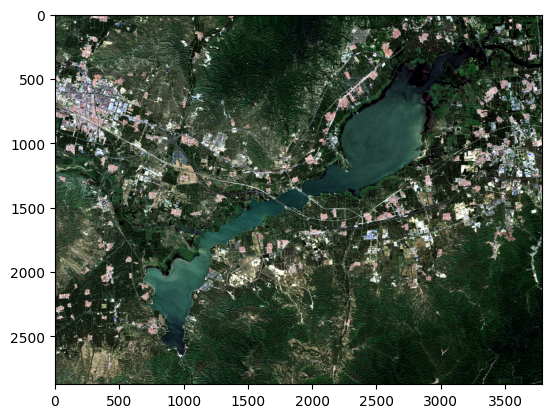

In [3]:
new_stack = "./data/T50TLK_20220825T030519/T50TLK_20220825T030519_clip.tif"
out_path='./data/T50TLK_20220825T030519/'
proj, geotrans, img_data, row, column  = read_img(new_stack)
# 显示重投影结果信息
print(f'仿射矩阵信息：{geotrans}',f'投影信息：{proj}',f'图像大小：{img_data.shape}')
img_data_=rgb(img_data)
plt.imshow(stretch_n(img_data_.copy()))

### 3. 水体指数计算

* NDWI（归一化差异水体指数）：NDWI = (GREEN-NIR)/(GREEN+NIR)
* MNDWI（改进的归一化差异水体指数）：MNDWI=(GREEN-SWIR)/(GREEN+SWIR)
* 通过直方图观察数值分布情况，初步定位阈值区间

0.0 30.031637


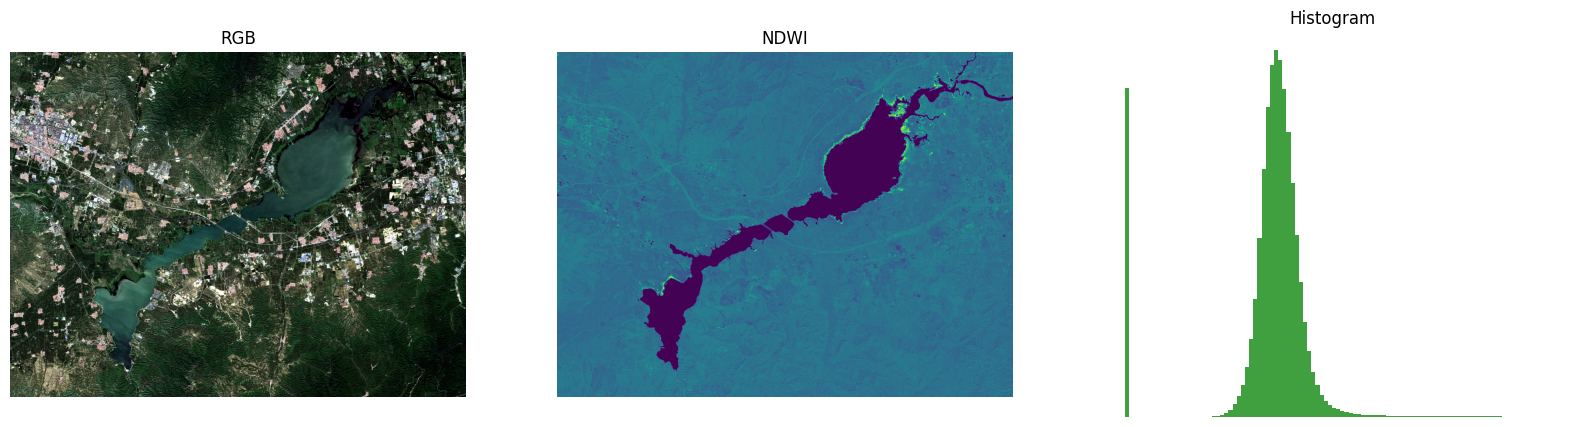

In [4]:
Green_arr = img_data[1,:,:]
NIR_arr   = img_data[3,:,:]

denominator = np.array(Green_arr + NIR_arr, dtype=np.float32)
numerator = np.array(Green_arr - NIR_arr, dtype=np.float32)
nodata = np.full((Green_arr.shape[0], Green_arr.shape[1]), -2, dtype=np.float32)
ndwi = np.true_divide(numerator, denominator, out=nodata, where=denominator != 0.0)
print(np.min(ndwi),np.max(ndwi))
ndwi[ndwi == -2.0]=None

ndwipath=out_path+'ndwi.tif'
Write_Tiff(np.uint8(ndwi), geotrans,proj, ndwipath)

fig, axes = plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1),plt.title('RGB'), plt.axis('off')
plt.imshow(stretch_n(img_data_.copy()))
plt.subplot(1,3,2),plt.title('NDWI'), plt.axis('off')
plt.imshow(ndwi)
# plt.style.use("ggplot")
plt.subplot(1,3,3),plt.title('Histogram'), plt.axis('off')
plt.hist(ndwi.ravel(), bins=100, density=None, facecolor='green', alpha=0.75)
plt.show()

通过可视化查看不同阈值条件下水体提取效果

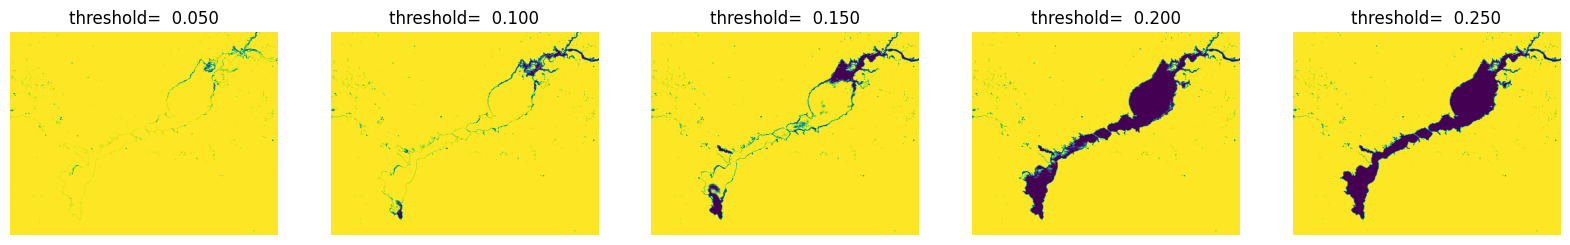

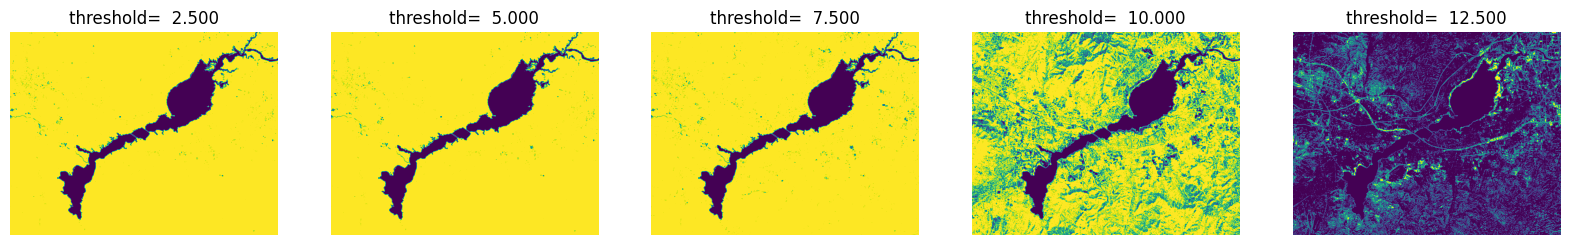

In [5]:
fig = plt.figure(figsize=(20,6))
for i in range(5):
    ndwi_ = ndwi.copy()
    threshold = (i+1) *0.05
    plt.subplot(1,5,i+1),plt.title('threshold=  %.3f' % threshold), plt.axis('off')
    ndwi_ [ndwi_ >threshold] = 255
    ndwi_ [ndwi_ <=threshold] = 0
    plt.imshow(Image.fromarray(np.uint8(ndwi_)))
plt.show()
fig = plt.figure(figsize=(20,6))
for i in range(5):
    ndwi_ = ndwi.copy()
    threshold = (i+1) *2.5
    plt.subplot(1,5,i+1),plt.title('threshold=  %.3f' % threshold), plt.axis('off')
    ndwi_ [ndwi_ >threshold] = 255
    ndwi_ [ndwi_ <=threshold] = 0
    plt.imshow(Image.fromarray(np.uint8(ndwi_)))
plt.show()

对比NDWI和mNDWI的效果

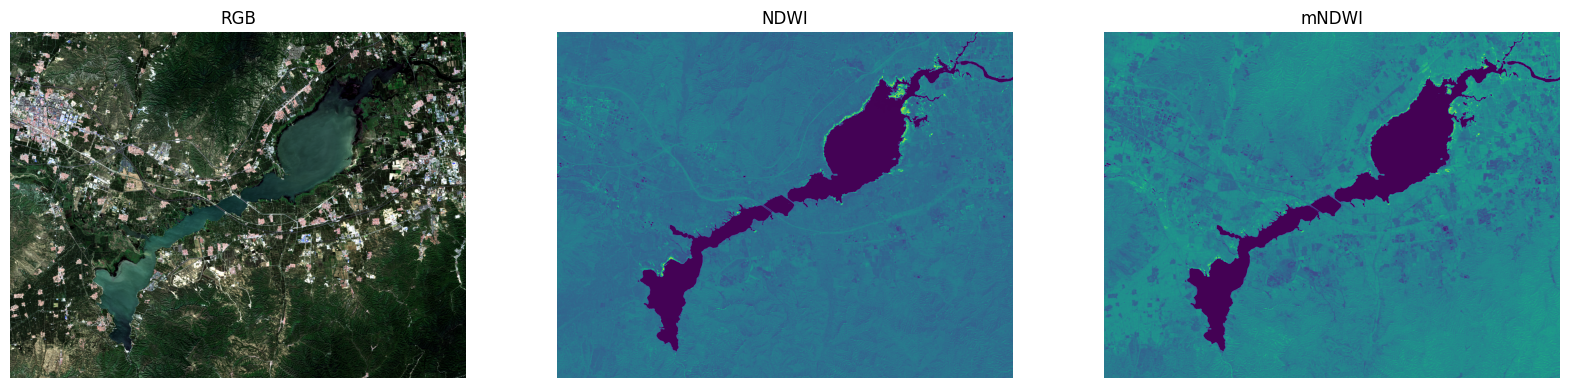

In [6]:
Green_arr = img_data[1,:,:]
SWIR_arr   = img_data[5,:,:]

denominator = np.array(Green_arr + SWIR_arr, dtype=np.float32)
numerator = np.array(Green_arr - SWIR_arr, dtype=np.float32)
nodata = np.full((Green_arr.shape[0], Green_arr.shape[1]), -2, dtype=np.float32)
mndwi = np.true_divide(numerator, denominator, out=nodata, where=denominator != 0.0)
mndwi[mndwi == -2.0]=None
fig, axes = plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1),plt.title('RGB'), plt.axis('off')
plt.imshow(stretch_n(img_data_.copy()))
plt.subplot(1,3,2),plt.title('NDWI'), plt.axis('off')
plt.imshow(ndwi)
plt.subplot(1,3,3),plt.title('mNDWI'), plt.axis('off')
plt.imshow(Image.fromarray(np.uint8(mndwi)))
plt.show()

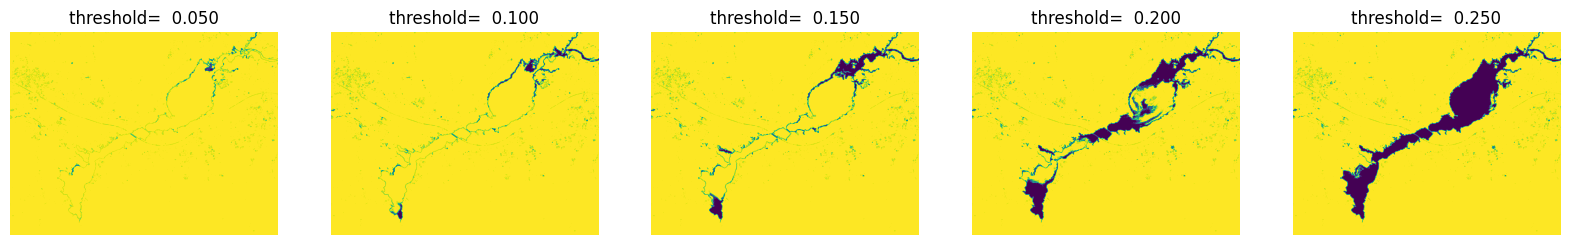

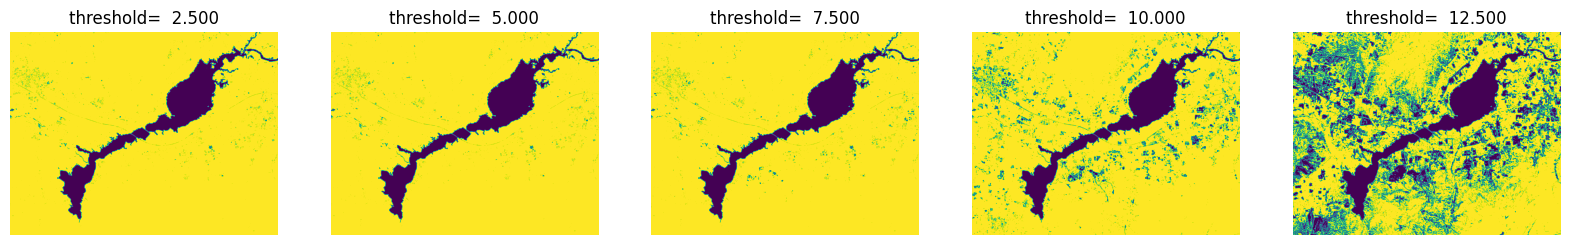

In [7]:
fig = plt.figure(figsize=(20,6))
for i in range(5):
    ndwi_ = mndwi.copy()
    threshold = (i+1) *0.05
    plt.subplot(1,5,i+1),plt.title('threshold=  %.3f' % threshold), plt.axis('off')
    ndwi_ [ndwi_ >threshold] = 255
    ndwi_ [ndwi_ <=threshold] = 0
    plt.imshow(Image.fromarray(np.uint8(ndwi_)))
plt.show()
fig = plt.figure(figsize=(20,6))
for i in range(5):
    ndwi_ = mndwi.copy()
    threshold = (i+1) *2.5
    plt.subplot(1,5,i+1),plt.title('threshold=  %.3f' % threshold), plt.axis('off')
    ndwi_ [ndwi_ >threshold] = 255
    ndwi_ [ndwi_ <=threshold] = 0
    plt.imshow(Image.fromarray(np.uint8(ndwi_)))
plt.show()

阈值分割进行二值化处理得到水体掩膜

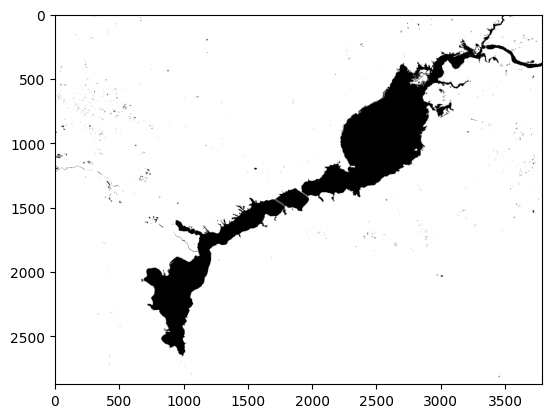

In [8]:
ndwi_ = ndwi.copy()
threshold = 2.5
ndwi_ [ndwi_ >threshold] = 255
ndwi_ [ndwi_ <=threshold] = 0
plt.imshow(Image.fromarray(np.uint8(ndwi_)),cmap='gray')
out_ndwi=out_path+'out_ndwi.tif'
Write_Tiff(np.uint8(ndwi_), geotrans,proj, out_ndwi)


### 4. 去除小图斑

* 使用阈值分割法会使图像上布满不规则小图斑，影响分割精度
* 利用滤波等候处理方法降低结果噪声

In [9]:
 
def Speckle_removal(tif_path, save_path,  remove_pixels =100, neighbours = 8 ):

    filename = os.path.basename(tif_path)
    output_path = os.path.join(save_path, filename[:-4] + '_sr.tif' )

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    shutil.copy(tif_path, output_path)
 
    # remove_pixels =100    #碎斑像素
    # neighbours = 8    #连通域， 4或8
    Image = gdal.Open(output_path, 1)  # open image in read-write mode
    Band = Image.GetRasterBand(1)
    gdal.SieveFilter(srcBand=Band, maskBand=None, dstBand=Band,
                    threshold= remove_pixels, 
                    connectedness= neighbours,
                    callback=gdal.TermProgress_nocb)
 
    del Image, Band  # close the datasets.
    return output_path

In [10]:
sr_out = Speckle_removal(out_ndwi, out_path,  remove_pixels =1000, neighbours = 8 )
proj, geotrans, sr_arr, row, column  = read_img(sr_out)
sr_arr.shape

(2874, 3789)

对比后处理前后变化

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28856\1761671902.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1),plt.title('NDWI'), plt.axis('off')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28856\1761671902.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,2),plt.title('NDWI_sr'), plt.axis('off')


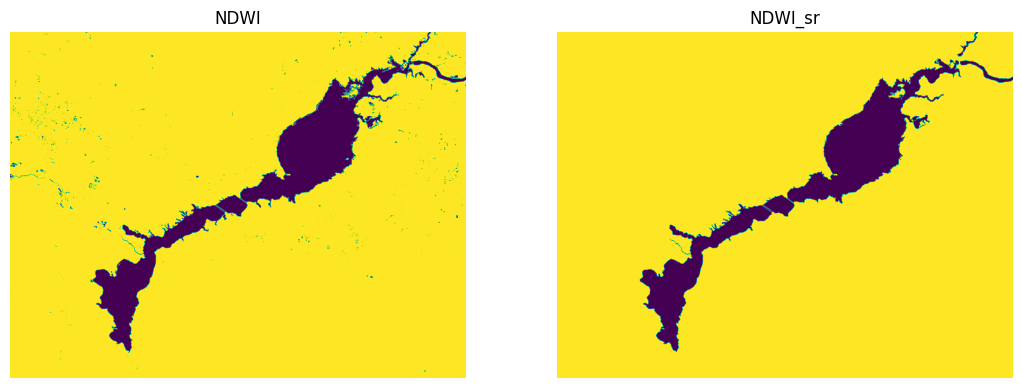

In [11]:
proj, geotrans, sr_arr, row, column  = read_img(sr_out)
fig, axes = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,3,1),plt.title('NDWI'), plt.axis('off')
plt.imshow(Image.fromarray(np.uint8(ndwi_)))
plt.subplot(1,3,2),plt.title('NDWI_sr'), plt.axis('off')
plt.imshow(sr_arr)
plt.show()

二值化栅格转矢量输出

In [12]:
def tif_to_shp(tif_path, shp_save_path):
    inraster = gdal.Open(tif_path)  # 读取路径中的栅格数据
    inband = inraster.GetRasterBand(1)  # 这个波段就是最后想要转为矢量的波段，如果是单波段数据的话那就都是1
    prj = osr.SpatialReference()
    prj.ImportFromWkt(inraster.GetProjection())  # 读取栅格数据的投影信息，用来为后面生成的矢量做准备
    outshp = shp_save_path + os.path.basename(tif_path)[:-4] + '.shp'  # 给后面生成的矢量准备一个输出文件名，这里就是把原栅格的文件名后缀名改成shp了

    drv = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outshp):  # 若文件已经存在，则删除它继续重新做一遍
        drv.DeleteDataSource(outshp)
    Polygon = drv.CreateDataSource(outshp)  # 创建一个目标文件
    Poly_layer = Polygon.CreateLayer(os.path.basename(tif_path)[:-4], srs=prj, geom_type=ogr.wkbMultiPolygon)  # 对shp文件创建一个图层，定义为多个面类
    newField = ogr.FieldDefn('value', ogr.OFTReal)  # 给目标shp文件添加一个字段，用来存储原始栅格的pixel value,浮点型，
    Poly_layer.CreateField(newField)

    gdal.Polygonize(inband, None, Poly_layer, 0)  # 核心函数，执行的就是栅格转矢量操作

    Polygon.SyncToDisk()
    Polygon = None
    return outshp


In [13]:
# 执行转换函数，获取存储路径
ndwi_shp = tif_to_shp(sr_out,out_path)

### 5. 成果出图

* 利用rasterio更容易实现将shape文件与栅格影像进行叠加显示
* plt.imshow更适合临时出图，更专业的出版需求通常采用axs这种方式实现

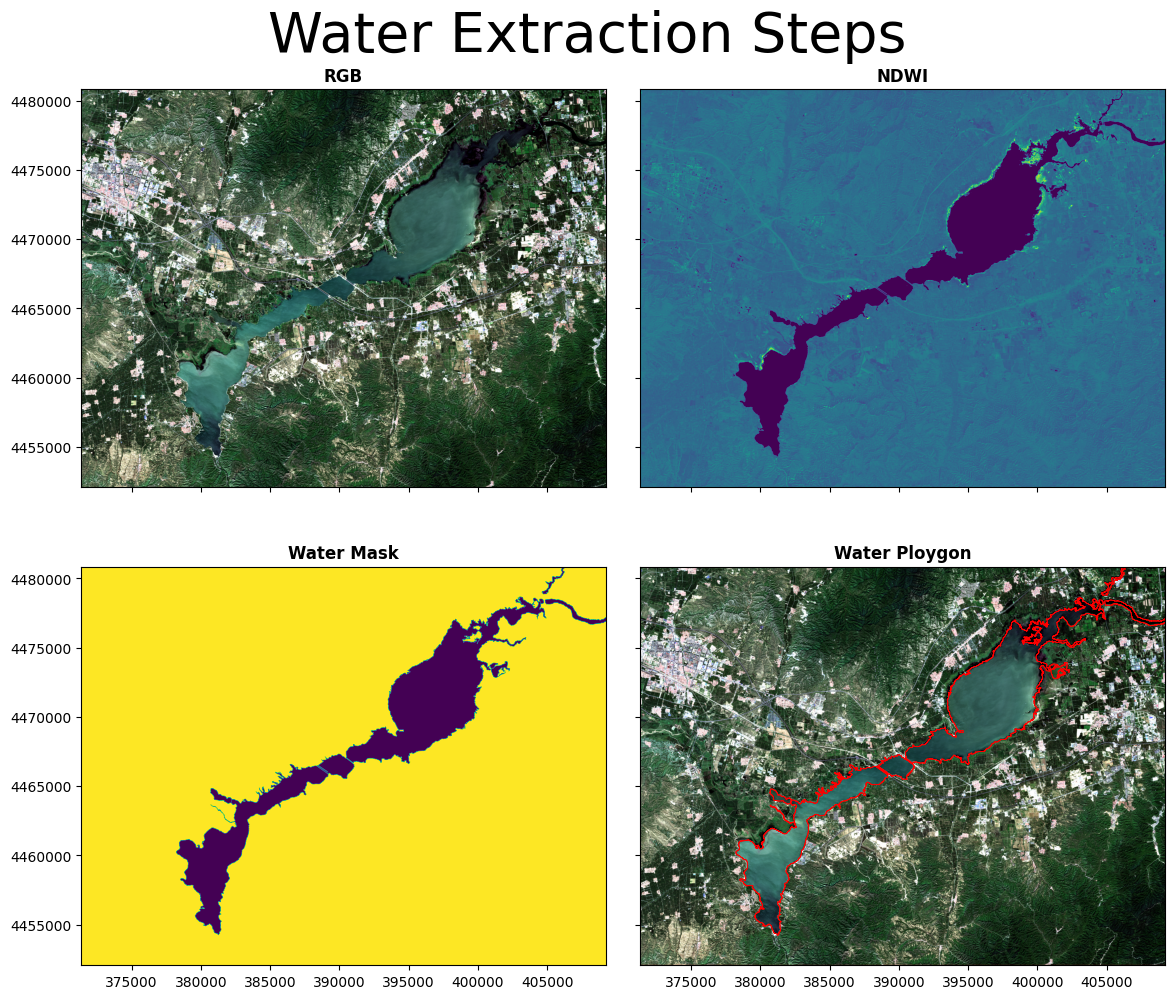

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

vector = gpd.read_file(ndwi_shp)
img=rasterio.open(out_path+"T50TLK_20220825T030519_quickclip.tif")

ndwiimg=rasterio.open(ndwipath)
srimg=rasterio.open(sr_out)
p1 =rasterio.plot.show(img, ax=axs[0,0],title='RGB')
ndwi =rasterio.plot.show(ndwiimg, ax=axs[0,1],title='NDWI')
sr =rasterio.plot.show(srimg, ax=axs[1,0],title='Water Mask')
p1 =rasterio.plot.show(img, ax=axs[1,1],title='Water Ploygon')
vector.plot(ax=axs[1,1],edgecolor='red', linewidth=0.5,facecolor='none')
fig.suptitle('Water Extraction Steps', fontsize=40)

for ax in fig.get_axes():
    ax.label_outer()
    ax.ticklabel_format(style ='plain') 
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.2)

fig.savefig(out_path+"T50TLK_20220825T030519_result.png",facecolor='white')